In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import yaml
import seaborn as sns
import pypsa
plt.style.use("bmh")
%matplotlib inline

In [10]:
with open("config.yaml", 'r') as stream:
    config = yaml.safe_load(stream)

In [11]:
n = pypsa.Network("networks/elec_s_100_ec_lcopt_3H-solar+1.0-onwind+1.5-offwind+1.0-H2+1.0-battery+0.5.nc")
twkm_orig = n.lines.eval("s_nom * length / 1e6").sum() + n.links.eval("p_nom * length / 1e6").sum()

INFO:pypsa.io:Imported network elec_s_100_ec_lcopt_3H-solar+1.0-onwind+1.5-offwind+1.0-H2+1.0-battery+0.5.nc has buses, carriers, generators, lines, links, loads, storage_units


In [13]:
def load_data(fn):

    df = pd.read_csv(fn, index_col=0, header=[0,1,2,3,4]).T

    df["offwind"] = df["offwind-ac"] + df["offwind-dc"]
    df["wind"] = df["onwind"] + df["offwind"]
    df["transmission"] = df["lines"] + df["links"] + twkm_orig

    df.drop(["ror", "hydro", 'PHS', 'offwind-ac', 'offwind-dc', 'lines', 'links'], axis=1, inplace=True)
    
    return df

In [29]:
st = 25

In [30]:
df = load_data(f"capacities-{st}.csv")

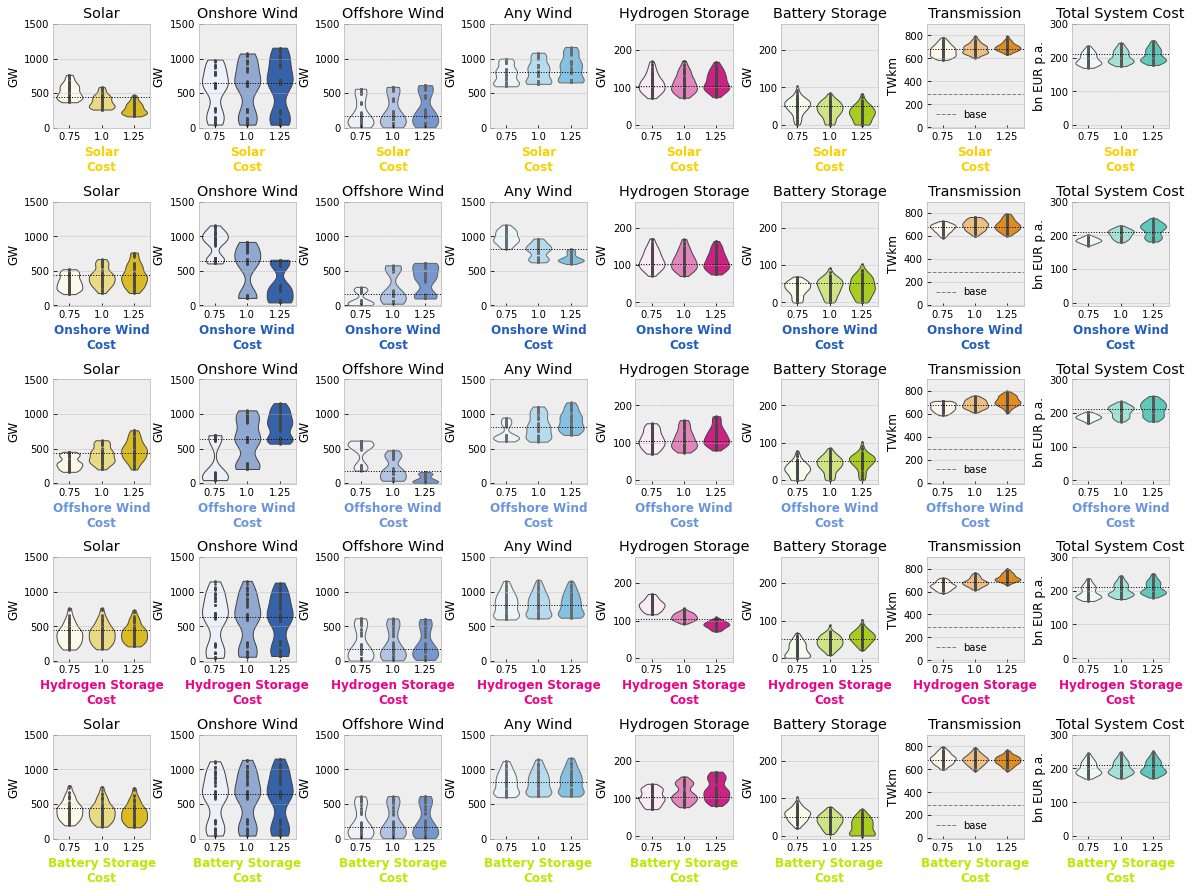

In [31]:
len_stats = len(df.columns)
len_sensitivities = len(df.index.names)
default = df.loc[5*("1.0",),:]
fig, axes = plt.subplots(len_sensitivities, len_stats, figsize=(20,15), gridspec_kw={"hspace": 0.7, "wspace": 0.5})
for i, a in enumerate(df.index.names):
    for j, b in enumerate(["solar", "onwind", "offwind", "wind", "H2", "battery", "transmission", "tsc"]):
        ax = axes[i,j]
        if b == 'transmission':
            ax.set_ylabel("TWkm")
            c = -0.25
            ax.set_ylim([-10,900])
            ax.axhline(twkm_orig, linewidth=1, linestyle="--", color='gray', label='base')
            ax.legend(frameon=False)
        elif b == 'tsc':
            ax.set_ylabel("bn EUR p.a.")
            ax.set_ylim([-10,300])
            c = -0.05
        elif b in ["H2", "battery"]:
            ax.set_ylabel("GW")
            c = 0.1
            ax.set_ylim([-10,270])
        else:
            ax.set_ylabel("GW")
            c = -0.5
            ax.set_ylim([-10,1500])
        #pal = sns.cubehelix_palette(3, rot=c, dark=.3)
        c = config["plotting"]["tech_colors"]
        nn = config["plotting"]["nice_names"]
        pal = sns.light_palette(c[b], 3)
        sns.violinplot(ax=ax, data=df.unstack(a)[b], inner='points', linewidth=1, cut=0, scale='count', palette=pal)
        ax.set_title(nn[b])#, fontdict={"fontweight": 3})
        label = a.split("-")
        ax.set_xlabel(f"{nn[label[0]]}\nCost", fontdict={"color": c[label[0]], "fontweight": 'semibold'})
        ax.axhline(default[b], linewidth=1, color='k', linestyle=":")
plt.savefig(f"matrix-{st}.pdf", bbox_inches='tight')

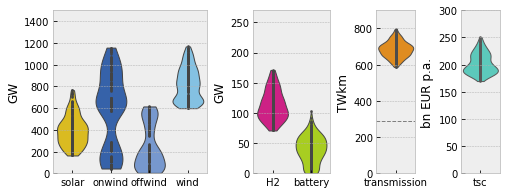

In [32]:
fig, axes = plt.subplots(1,4,figsize=(8,3), gridspec_kw={"width_ratios": [4,2,1,1], "hspace": 0.5, "wspace": 0.6})
c = config["plotting"]["tech_colors"]
sel = ["solar", "onwind", "offwind", "wind"]
sns.violinplot(ax=axes[0], data=df[sel], inner='points', cut=0, scale='width', linewidth=1, palette=[c[s] for s in sel])
sel = ["H2", "battery"]
sns.violinplot(ax=axes[1], data=df[sel], inner='points', cut=0, scale='width', linewidth=1, palette=[c[s] for s in sel])
sel = ["transmission"]
sns.violinplot(ax=axes[2], data=df[sel], inner='points', cut=0, scale='width', linewidth=1, palette=[c[s] for s in sel])
sel = ["tsc"]
sns.violinplot(ax=axes[3], data=df[sel], inner='points', cut=0, scale='width', linewidth=1, palette=[c[s] for s in sel])
axes[2].axhline(twkm_orig, linewidth=1, linestyle="--", color='gray', label='base')
axes[2].set_ylim([0,900])
axes[3].set_ylim([0,300])
axes[1].set_ylim([0,270])
axes[0].set_ylim([0,1500])
axes[0].set_ylabel("GW")
axes[1].set_ylabel("GW")
axes[2].set_ylabel("TWkm")
axes[3].set_ylabel("bn EUR p.a.");
plt.savefig(f"capacity-range-{st}.pdf", bbox_inches='tight')